# Sentiment Classifier for Twitter Political Data   
This notebook explains in detail various steps for a sentiment classifier for analyzing political tweets. The steps we've taken have been broken into stages (represented as `<stage number> - <stage name>`). Our solution can quickly extract the text data features to highlight the hot keywords which are re-tweeted more than once, and apply a machine learning algorithm to understand if there is any correlation between what’s going on twitter and the actual results in the elections.

# 1 - Getting Started
In this stage, we:

a. Install and import all dependencies required for the challenge.

b. Initialize Spark Session.

c. Read and cache dataset.

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f0d7e6cf8e1978c76ddc7f44ac6de0f4be4782d579d916a098ccc8be0c814c63
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
pip install textblob

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/My Drive/notebooks'

/content/drive/My Drive/notebooks


In [5]:
import matplotlib.pyplot as plt
!pip install textblob

In [6]:
%matplotlib inline
from src.jobs.spark_etl import extract
from src.utils.spark import initSparkSession
from src.utils.dataset import getPolarity
from src.transforms.Preprocessing import CleanTweet, polarityCalculator
from sklearn.preprocessing import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, NGram, VectorAssembler, SQLTransformer, HashingTF, IDF, StringIndexer, ChiSqSelector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

In [10]:
# Spark Session for ETL job
sparkSession = initSparkSession(appName='Preprocessing')
sparkSession

In [13]:
df_result = sparkSession.read.csv('/content/drive/MyDrive/notebooks/data/voting.csv',header=True,inferSchema=True)
df_result.cache()
df_result.show()


+------------+---------+---------+---------+----------+----------+---------+---------+
|       state|state_abr|trump_pct|biden_pct|trump_vote|biden_vote|trump_win|biden_win|
+------------+---------+---------+---------+----------+----------+---------+---------+
|      Alaska|       AK|     53.1|     43.0|    189543|    153502|        1|        0|
|      Hawaii|       HI|     34.3|     63.7|    196864|    366130|        0|        1|
|  Washington|       WA|     39.0|     58.4|   1584651|   2369612|        0|        1|
|      Oregon|       OR|     40.7|     56.9|    958448|   1340383|        0|        1|
|  California|       CA|     34.3|     63.5|   5982194|  11082293|        0|        1|
|       Idaho|       ID|     63.9|     33.1|    554128|    287031|        1|        0|
|     Montana|       MT|     56.9|     40.6|    343647|    244836|        1|        0|
|      Nevada|       NV|     47.7|     50.1|    669890|    703486|        0|        1|
|     Wyoming|       WY|     70.4|     26.7

In [14]:
df_result.printSchema()

root
 |-- state: string (nullable = true)
 |-- state_abr: string (nullable = true)
 |-- trump_pct: double (nullable = true)
 |-- biden_pct: double (nullable = true)
 |-- trump_vote: integer (nullable = true)
 |-- biden_vote: integer (nullable = true)
 |-- trump_win: integer (nullable = true)
 |-- biden_win: integer (nullable = true)



In [15]:
df = extract(sparkSession)
df_train, df_test = df.randomSplit([0.70, 0.30], seed=123456)
df_train.cache()
df_test.cache()

DataFrame[created_at: timestamp, tweet_id: string, tweet: string, likes: float, retweet_count: float, source: string, user_id: string, user_name: string, user_screen_name: string, user_description: string, user_join_date: timestamp, user_followers_count: float, user_location: string, lat: double, long: double, city: string, country: string, continent: string, state: string, state_code: string, collected_at: timestamp, candidate: string]

In [9]:
df.createOrReplaceTempView("politicalTweets")
df.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- likes: float (nullable = true)
 |-- retweet_count: float (nullable = true)
 |-- source: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_join_date: timestamp (nullable = true)
 |-- user_followers_count: float (nullable = true)
 |-- user_location: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- collected_at: timestamp (nullable = true)
 |-- candidate: string (nullable = false)



# 2 - Spark User Defined Function (UDF)
In this stage, we implement an UDF for labelling our dataset using a rule-based algorithm.

In [16]:
polarity = sparkSession.udf.register('Polarity', lambda record: getPolarity(record))

# 3 - Pipeline
We've combined the best combination of stages for maximum possible model accuracy from our analyses in Notebooks `Sentiment Classifier LR` and `Sentiment Classifier NB`.

In [18]:
def pipelineCv():
    cleanTweet = CleanTweet()
    regexTokenizer = RegexTokenizer(inputCol="cleaned_tweet", outputCol="cleaned_tweet_words", pattern="[^a-zA-Z0-9_#]")
    stopWordsRemover = StopWordsRemover(inputCol='cleaned_tweet_words', outputCol='cleaned_tweet_nostop')
    polarityCalc = polarityCalculator()
    countVectorizer = CountVectorizer(inputCol='cleaned_tweet_nostop', outputCol='cv')
    idf = IDF(inputCol='cv', outputCol="features")
    sentimentStringIdx = StringIndexer(inputCol = "polarity", outputCol = "label")
    logisticRegression = LogisticRegression()  # defaulted to featuresCol='features', labelCol='label'

    dataCleaningStages = [cleanTweet, regexTokenizer, stopWordsRemover]
    featureLabelMapStages = [countVectorizer, idf, sentimentStringIdx]

    return Pipeline(stages=dataCleaningStages+[polarityCalc]+featureLabelMapStages+[logisticRegression]), logisticRegression

In [19]:
pipeline, _ = pipelineCv()
pipelineModel = pipeline.fit(df_train)
predictions = pipelineModel.transform(df_test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7883607446231701
Precision: 0.7886848168264928
Recall: 0.78836074462317


In [20]:
predictions.show(10)

+--------------------+-------------------+--------------------+-----+-------------+-------------------+--------------------+-------------------+--------------------+-------------------+------------------+------------------+-----------+--------------------+----------+--------------------+---------+--------------------+--------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|            tweet_id|         created_at|               tweet|likes|retweet_count|             source|             user_id|     user_join_date|user_followers_count|      user_location|               lat|              long|       city|               state|state_code|               tweet|candidate|cleaned_tweet_nostop|polarity|                  cv|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-------------------+--------------------+-----+-------------+-------------------+--------------------+----------------

In [21]:
from pyspark.sql.functions import sum, col

polarity_df = predictions.groupBy("state", "candidate") \
                         .agg(sum("prediction").alias("sum_polarity"))

polarity_df.show()

+--------------------+---------+------------+
|               state|candidate|sum_polarity|
+--------------------+---------+------------+
|      South Carolina|    TRUMP|        29.0|
|        Rhode Island|    TRUMP|        13.0|
|             Alabama|    TRUMP|         8.0|
|              Hawaii|    TRUMP|        20.0|
|            Michigan|    TRUMP|         9.0|
|          New Jersey|    TRUMP|        32.0|
|            Missouri|    TRUMP|        11.0|
|             Georgia|    TRUMP|        35.0|
|              Alaska|    TRUMP|         0.0|
|            Kentucky|    TRUMP|        23.0|
|                NULL|    TRUMP|       256.0|
|               Texas|    TRUMP|       139.0|
|            New York|    TRUMP|       326.0|
|           Minnesota|    TRUMP|        19.0|
|            Nebraska|    TRUMP|         4.0|
|            Virginia|    TRUMP|        25.0|
|District of Columbia|    TRUMP|       202.0|
|            Maryland|    TRUMP|        11.0|
|       West Virginia|    TRUMP|  

In [22]:
combined_df = polarity_df.join(df_result, "state")
combined_df.show(100)

+--------------------+---------+------------+---------+---------+---------+----------+----------+---------+---------+
|               state|candidate|sum_polarity|state_abr|trump_pct|biden_pct|trump_vote|biden_vote|trump_win|biden_win|
+--------------------+---------+------------+---------+---------+---------+----------+----------+---------+---------+
|      South Carolina|    TRUMP|        29.0|       SC|     55.1|     43.4|   1385103|   1091541|        1|        0|
|        Rhode Island|    TRUMP|        13.0|       RI|     38.8|     59.7|    199922|    307486|        0|        1|
|             Alabama|    TRUMP|         8.0|       AL|     62.2|     36.7|   1441170|    849624|        1|        0|
|              Hawaii|    TRUMP|        20.0|       HI|     34.3|     63.7|    196864|    366130|        0|        1|
|            Michigan|    TRUMP|         9.0|       MI|     47.8|     50.6|   2649842|   2804040|        0|        1|
|          New Jersey|    TRUMP|        32.0|       NJ| 

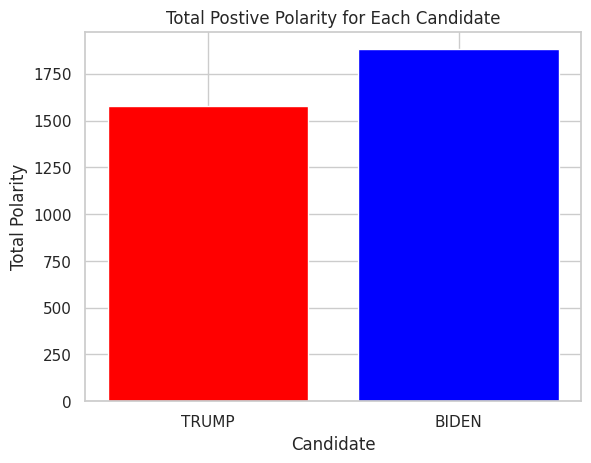

In [44]:
import pyspark.sql.functions as F



sum_polarity_df = combined_df.groupBy("candidate").agg(sum("sum_polarity").alias("total_polarity"),
                                                       sum("trump_vote").alias("total_votes_trump"),
                                                       sum("biden_vote").alias("total_votes_biden") )


pandas_df = sum_polarity_df.toPandas()


plt.bar(pandas_df['candidate'], pandas_df['total_polarity'], color=['red', 'blue'])
plt.xlabel('Candidate')
plt.ylabel('Total Polarity')
plt.title('Total Postive Polarity for Each Candidate')
plt.show()

In [45]:
# Create DataFrame with condition on a column
df_trump = combined_df.filter(combined_df['candidate'] == "TRUMP")
df_biden = combined_df.filter(combined_df['candidate'] == "BIDEN")

In [46]:
# Show the DataFrames
df_trump.show()
df_biden.show()

+--------------------+---------+------------+---------+---------+---------+----------+----------+---------+---------+
|               state|candidate|sum_polarity|state_abr|trump_pct|biden_pct|trump_vote|biden_vote|trump_win|biden_win|
+--------------------+---------+------------+---------+---------+---------+----------+----------+---------+---------+
|      South Carolina|    TRUMP|        29.0|       SC|     55.1|     43.4|   1385103|   1091541|        1|        0|
|        Rhode Island|    TRUMP|        13.0|       RI|     38.8|     59.7|    199922|    307486|        0|        1|
|             Alabama|    TRUMP|         8.0|       AL|     62.2|     36.7|   1441170|    849624|        1|        0|
|              Hawaii|    TRUMP|        20.0|       HI|     34.3|     63.7|    196864|    366130|        0|        1|
|            Michigan|    TRUMP|         9.0|       MI|     47.8|     50.6|   2649842|   2804040|        0|        1|
|          New Jersey|    TRUMP|        32.0|       NJ| 

In [47]:
from scipy.stats import pearsonr
#
x = df_biden.select("sum_polarity").rdd.flatMap(lambda x: x).collect()
y = df_biden.select("biden_vote").rdd.flatMap(lambda x: x).collect()
corr, p_value = pearsonr(x, y)


print("Pearson correlation coefficient for Biden:", corr)
print("p-value:", p_value)

Pearson correlation coefficient for Biden: 0.6717390908989669
p-value: 9.271534769055909e-08


In [48]:
from scipy.stats import pearsonr

x = df_trump.select("sum_polarity").rdd.flatMap(lambda x: x).collect()
y = df_trump.select("trump_vote").rdd.flatMap(lambda x: x).collect()
corr, p_value = pearsonr(x, y)


print("Pearson correlation coefficient for Tump:", corr)
print("p-value:", p_value)

Pearson correlation coefficient for Tump: 0.5312681234122698
p-value: 0.00014536206338746182


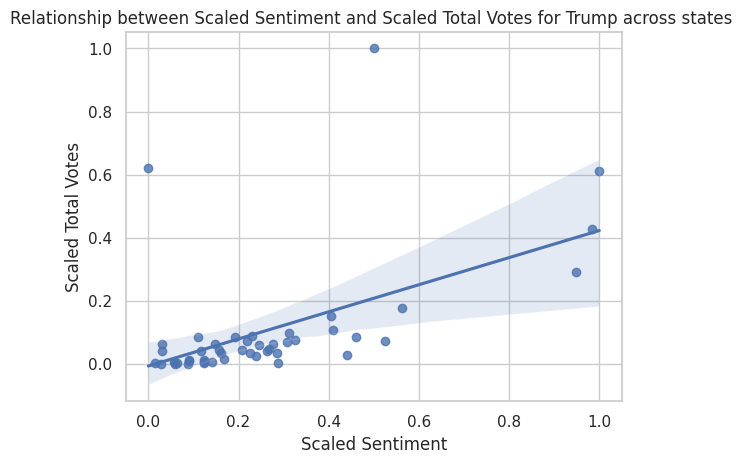

In [49]:

import seaborn as sns
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

pandas_df = df_trump.select("sum_polarity", "trump_vote").toPandas()
pandas_df


scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(pandas_df.to_numpy())

df_scaled
df_scaled = pd.DataFrame(df_scaled, columns=['sum_polarity_scaled', 'trump_vote_scaled'])

sns.set(style="whitegrid")
sns.regplot(x="trump_vote_scaled", y="sum_polarity_scaled", data=df_scaled)
plt.title("Relationship between Scaled Sentiment and Scaled Total Votes for Trump across states ")
plt.xlabel("Scaled Sentiment")
plt.ylabel("Scaled Total Votes")
plt.show()

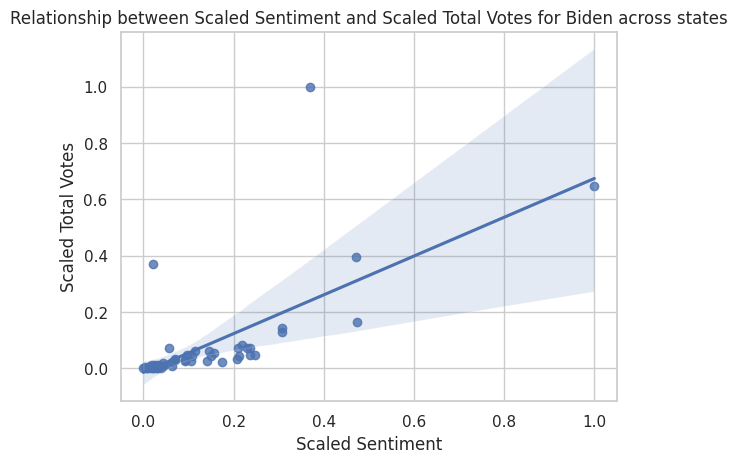

In [50]:
pandas_df = df_biden.select("sum_polarity", "biden_vote").toPandas()
pandas_df


scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(pandas_df.to_numpy())

df_scaled
df_scaled = pd.DataFrame(df_scaled, columns=['sum_polarity_scaled', 'biden_vote_scaled'])

sns.set(style="whitegrid")
sns.regplot(x="biden_vote_scaled", y="sum_polarity_scaled", data=df_scaled)
plt.title("Relationship between Scaled Sentiment and Scaled Total Votes for Biden across states")
plt.xlabel("Scaled Sentiment")
plt.ylabel("Scaled Total Votes")
plt.show()


# 4 - Fine-tuning
In this stage, we experiment with cross-validation and the lesser expensive train-validation split for fine-tuning our models.

## 4.1 Cross-Validation

In [ ]:
# 10-fold cross-validation
pipeline, logisticRegression = pipelineCv()

paramGrid = ParamGridBuilder() \
    .addGrid(logisticRegression.maxIter, [100, 200, 300]) \
    .addGrid(logisticRegression.regParam, [0.1, 0.01]) \
    .build()

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
crossVal = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10, seed=123456)
crossValModel = crossVal.fit(df_train)
predictions = crossValModel.transform(df_test)
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

24/05/10 20:27:12 WARN MemoryStore: Not enough space to cache rdd_328_0 in memory! (computed 154.1 MiB so far)
24/05/10 20:27:12 WARN BlockManager: Persisting block rdd_328_0 to disk instead.
24/05/10 20:27:16 WARN MemoryStore: Not enough space to cache rdd_328_1 in memory! (computed 160.7 MiB so far)
24/05/10 20:27:16 WARN BlockManager: Persisting block rdd_328_1 to disk instead.
24/05/10 20:27:17 WARN MemoryStore: Not enough space to cache rdd_328_0 in memory! (computed 249.6 MiB so far)
24/05/10 20:27:18 WARN MemoryStore: Not enough space to cache rdd_328_0 in memory! (computed 249.6 MiB so far)
24/05/10 20:27:19 WARN MemoryStore: Not enough space to cache rdd_328_0 in memory! (computed 249.6 MiB so far)
24/05/10 20:27:20 WARN MemoryStore: Not enough space to cache rdd_328_0 in memory! (computed 249.6 MiB so far)
24/05/10 20:27:22 WARN MemoryStore: Not enough space to cache rdd_328_0 in memory! (computed 249.6 MiB so far)
24/05/10 20:27:26 WARN MemoryStore: Not enough space to cache

Accuracy: 0.7941442255557564
Precision: 0.7937925198368496
Recall: 0.7941442255557563


In [ ]:
bestPipelineModel = crossValModel.bestModel
bestModel = bestPipelineModel.stages[-1]
bestParams = bestModel.extractParamMap()

In [ ]:
sparkSession.stop()